In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from google.colab.patches import cv2_imshow

In [2]:
# set transformation option
transform = transforms.Compose([
        transforms.ToTensor(), # scales data to the range [0,1]
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))]) # normalizes scaled data

test_set = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16462850.72it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494695.91it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4542979.58it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10319896.41it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
batch_size = 1
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False)

In [4]:
# Loading the trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
file_name = 'resnet18.pth'
model = torch.load(file_name,map_location=device)

In [5]:
def vis(images):
  for img in images:
    img = torch.Tensor.numpy(img,force=True)
    img = np.squeeze(img)
    #print(img.shape)
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap='gray',vmin=0,vmax=1)
    plt.show()
  #cv2_imshow(img)

In [6]:
def softmax(x):
  e_x = np.exp(x - np.max(x))

  return e_x / e_x.sum(axis=0)

In [7]:
def entropy(aug_preds_all):
  entropies = []
  for aug_preds in tqdm(aug_preds_all):
    #aug_preds = torch.Tensor.numpy(aug_preds,force=True)
    aug_preds = np.array(aug_preds)
    #outputs = np.squeeze(outputs)
    #print(outputs)
    probs = softmax(aug_preds)
    #print(probs)
    #print(np.sum(probs))
    log_probs = np.log2(probs)
    prods = np.multiply(probs,-log_probs)
    entropy = np.sum(prods)
    entropies.append(entropy)
    #print(entropy)

  #print(entropy)

  return entropies # returns entropies of all images in the test set

In [8]:
from statistics import mode
total_augs = 10

# set transformation option
tta_transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.RandomAffine(degrees = 10),
        transforms.RandomPerspective(),
        #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False), # Randomly erases rectangular areas of the image.
        transforms.GaussianBlur(kernel_size=5, sigma=1.5)])
        #transforms.RandomInvert(p=0.5), # Inverts the colors of the given image randomly with a given probability.])

def tta(tta_loader,tta_size, model, total_augs=10, tta_transform=tta_transform):
  correct_preds = 0
  aug_preds_all = []
  tta_modes_all = []
  labels = []
  tta_accs = []
  for image,label in tqdm(tta_loader):
    image = image.to(device)
    label = label.to(device)
    aug_preds = []
    tta_correct = 0
    for aug in range(total_augs):
      image_trans = tta_transform(image)
      outputs = model(image_trans)
      _, pred = torch.max(outputs, 1)
      aug_preds.append(int(pred[0]))
      if(int(label[0]) == int(pred[0])):
        tta_correct += 1

    tta_acc = tta_correct/total_augs
    #print(aug_preds)
    #break
    tta_mode = mode(aug_preds) # Mode of total_augs preds
    if(tta_mode == int(label[0])):
      correct_preds += 1
    #print(image.shape)
    #print(len(image))
    aug_preds_all.append(aug_preds)
    tta_modes_all.append(tta_mode)
    labels.append(int(label[0]))
    tta_accs.append(tta_acc)

  acc = correct_preds/tta_size

  return labels,tta_modes_all,aug_preds_all,tta_accs


In [9]:
from statistics import mode
total_augs = 15

def tta_entropy(data_loader, data_size, model, total_augs=10, tta_transform=tta_transform):
  df = pd.DataFrame(columns=['Image label (GT)', 'Pred Label (TTA Mode)', 'TTA Accuracy', 'Entropy'])
  print('Performing TTA')
  labels, tta_modes, aug_preds, tta_acc = tta(data_loader, data_size, model, total_augs=10, tta_transform=tta_transform)
  df['Image label (GT)'] = labels
  df['Pred Label (TTA Mode)'] = tta_modes
  df['TTA Accuracy']  = tta_acc
  print("Calculating Entropies")
  entropies = entropy(aug_preds)
  df['Entropy'] = entropies

  #print(df.head)

  return df

In [10]:
out_df = tta_entropy(test_loader, len(test_set), model)
print(out_df.head())

Performing TTA


100%|██████████| 10000/10000 [09:09<00:00, 18.19it/s]


Calculating Entropies


100%|██████████| 10000/10000 [00:00<00:00, 42792.56it/s]

   Image label (GT)  Pred Label (TTA Mode)  TTA Accuracy   Entropy
0                 7                      7           0.9  2.733774
1                 2                      2           0.8  0.689876
2                 1                      1           0.9  0.220726
3                 0                      0           0.8  0.288723
4                 4                      4           1.0  3.321928


In [11]:
out_df.to_csv('table.csv')

In [12]:
def avg_accuracy(gt,pred):
  correct = 0
  acc = 0
  for i,label in enumerate(gt):
    if(label == pred[i]):
      correct += 1
  acc = correct/len(gt) * 100

  return acc

In [13]:
def drop_rate_vs_avg_acc(df,drop_rates = [0,10,20,30,40,50,60,70,80,90,99]):
  """
  Takes df as input having the columns ['Image label (GT)', 'Pred Label (TTA Mode)', 'TTA Accuracy', 'Entropy'] and drops
  drop_rate % of the rows which have the highest entropy. We then calculate the avg_tta_acc and avg_acc
  """
  avg_tta_accs = []
  avg_accs = []
  for drop_rate in drop_rates:
    #print("Drop rate=",drop_rate)
    # Sort the DataFrame in descending order of column 'B'
    df_sorted = df.sort_values(by='Entropy', ascending=False,ignore_index=True)
    #print(df_sorted.head())
    # Calculate the number of rows to drop (drop_rate% of total rows)
    rows_to_drop = int(drop_rate/100.0 * df_sorted.shape[0])
    #print(rows_to_drop)
    # Drop the top drop_rate% rows
    filtered_df = df_sorted.iloc[rows_to_drop:]
    #print(filtered_df.head())
    #print(len(filtered_df))
    #print(filtered_df.head())
    gt=list(filtered_df['Image label (GT)'])
    pred=list(filtered_df['Pred Label (TTA Mode)'])
    avg_acc = avg_accuracy(gt,pred)
    #print(avg_acc)
    avg_tta_acc = filtered_df['TTA Accuracy'].mean() * 100

    avg_accs.append(avg_acc)
    avg_tta_accs.append(avg_tta_acc)

  return avg_accs, avg_tta_accs, drop_rates


In [14]:
def plot(drop_rates, avg_accs,title = "Average accuracies vs drop rates"):
  plt.plot(drop_rates,avg_accs,marker='o')
  for xy in zip(drop_rates, avg_accs):
   plt.annotate('(%.2f, %.2f)' % xy, xy=xy,rotation=60)
  plt.ylabel("Average accuracy")
  plt.xlabel("Drop rate")
  plt.title(title)
  plt.show()

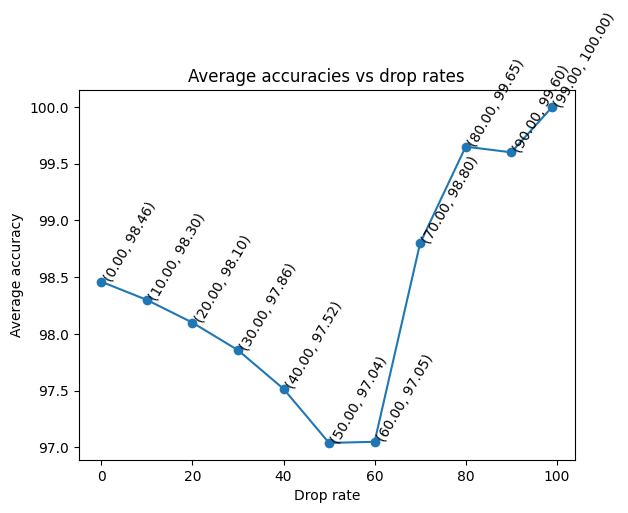

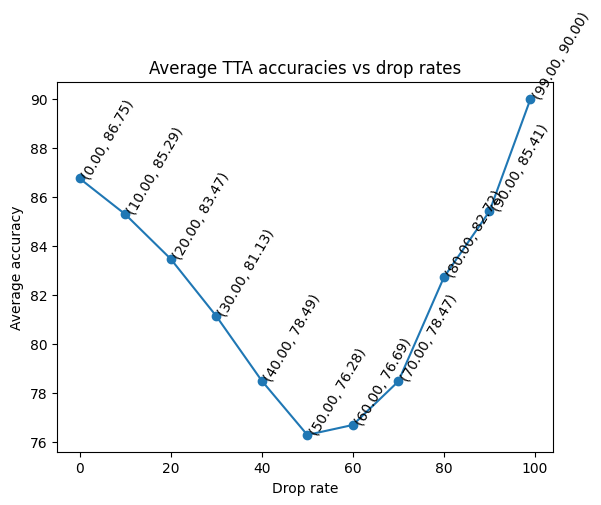

In [15]:
avg_accs, avg_tta_accs, drop_rates = drop_rate_vs_avg_acc(out_df)
plot(drop_rates,avg_accs)
plot(drop_rates,avg_tta_accs,title="Average TTA accuracies vs drop rates")